In [94]:
import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

# Упражнение 6.1
В этой главе утверждается, что analyze1 требует времени пропорционально n^3, а analyze2 — пропорционально n^2. Убедитесь в этом, запуская их с несколькими разными массивами и засекая время рабо ты. В блокнотах Jupyter можно использовать «волшебную команду» %timeit.

Если печатать зависимость времени работы от размера на логарифмической шкале, то получится прямая линия с уклоном 3 для analyze1 и с уклоном 2 для analyze2.

Также стоит поупражняться с dct_iv и scipy.fftpack.dct.

In [95]:
import numpy as np
import scipy.fftpack

def analyze1(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(np.pi * 2 * args)
    amps = np.linalg.solve(M, ys)
    return amps

def analyze2(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(np.pi * 2 * args)
    amps = M.dot(ys) / 2
    return amps

def scipy_dct(ys, fs, ts):
    return scipy.fftpack.dct(ys, type=3)

In [96]:
from thinkdsp import UncorrelatedGaussianNoise
from scipy.stats import linregress

loglog = dict(xscale='log', yscale='log')

def plot_bests(ns, bests):
    plt.plot(ns, bests)
    decorate(**loglog)

    x = np.log(ns)
    y = np.log(bests)
    t = linregress(x,y)
    slope = t[0]

    return slope

signal = UncorrelatedGaussianNoise()
wave = signal.make_wave(duration=1.0, framerate=16384)
wave.ys.shape

def run_speed_test(ns, func):
    results = []
    for N in ns:
        print(N)
        ts = (0.5 + np.arange(N)) / N
        freqs = (0.5 + np.arange(N)) / 2
        ys = wave.ys[:N]
        result = %timeit -r1 -o func(ys, freqs, ts)
        results.append(result)

    bests = [result.best for result in results]
    return bests

In [97]:
ns = 2 ** np.arange(6, 13)
ns

array([  64,  128,  256,  512, 1024, 2048, 4096])

In [98]:
bests = run_speed_test(ns, analyze1)

64
256 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
128
2.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
256
3.62 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
512
18.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
75.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
404 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4096
3.17 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [99]:
bests2 = run_speed_test(ns, analyze2)

64
151 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
128
579 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
256
2.11 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
512
8.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
33.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
139 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
4096
525 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [100]:
bests3 = run_speed_test(ns, scipy_dct)

64
11.1 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
128
12.1 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
256
8.21 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
512
9.82 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
1024
13 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
2048
19.7 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
4096
37.9 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)


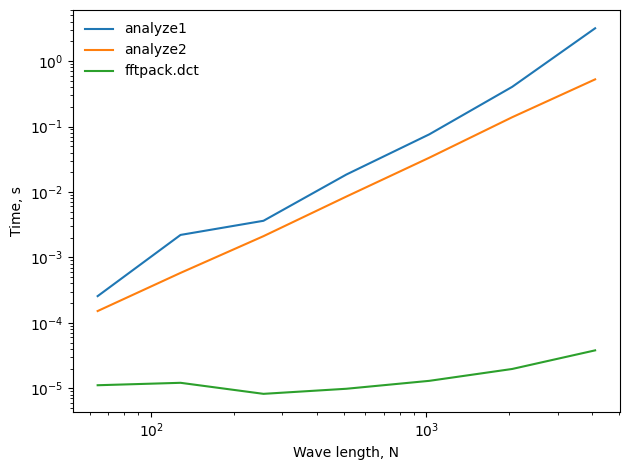

In [101]:
import matplotlib.pyplot as plt
from thinkdsp import decorate

plt.plot(ns, bests, label='analyze1')
plt.plot(ns, bests2, label='analyze2')
plt.plot(ns, bests3, label='fftpack.dct')
decorate(xlabel='Wave length, N', ylabel='Time, s', **loglog)

По графику видно, что analyze1, как и analyze2, показывает квадратическую зависимость от размера данных. Возможно, это проявляется только на данном диапазоне размеров.
fftpack.dct показал гораздо лучший результат.

# Упражнение 6.2

Одно из основных применений ДКП - это сжатие звука и изображений. В простейшей форме ДКП при сжатии работает следующим образом:

1. Разбивает длинный сигнал на сегменты.

2. Вычисляет ДКП каждого сегмента.

3. Определяет частотные компоненты с такой амплитудой, что их не слышно, и удаляет их, сохраняя только оставшиеся частоты и амплитуды.

4. При воспроизведении сигнала загружает частоты и амплитуды каждого сегмента и применяет обратное ДКП.

Реализуйте версию этого алгоритма и примените его для записи музыки или речи. Сколько компонент можно удалить до того, как разница станет заметной?

Для того, чтобы этот метод стал практичным, нужен способ хранения прореженного массива, то есть массива, где большинство элементов равно нулю. NumPy (SciPy)дает несколько способов работы с прореженными массивами; о них можно прочитать на веб-странице http://docs.scipy.org/doc/scipy/reference/sparse.html

In [102]:
def filter(dct,limit = 0):
    for i, amp in enumerate(dct.amps):
        if np.abs(amp) < limit:
              dct.hs[i] = 0

/content/thinkdsp.py:1113: RuntimeWarning: overflow encountered in scalar absolute
  high, low = abs(max(ys)), abs(min(ys))


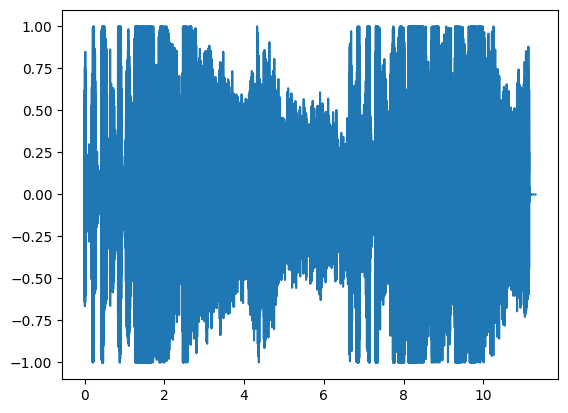

In [103]:
from thinkdsp import read_wave

if not os.path.exists('metro-boomin.wav'):
    !wget https://github.com/Ch0rtik/telecom/raw/main/chap_06/metro-boomin.wav

wave = read_wave('metro-boomin.wav')
wave.plot()
wave.normalize()
wave.make_audio()

In [104]:
segment = wave.segment(start=9.5, duration=1.0)
segment.normalize()
segment.make_audio()

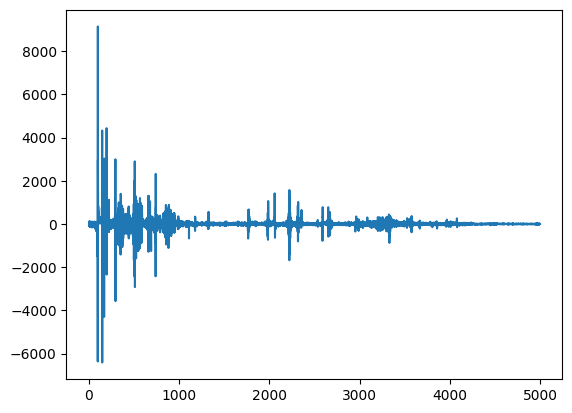

In [105]:
dct = segment.make_dct()
dct.plot(high = 5000)

In [106]:
filter(dct,100)

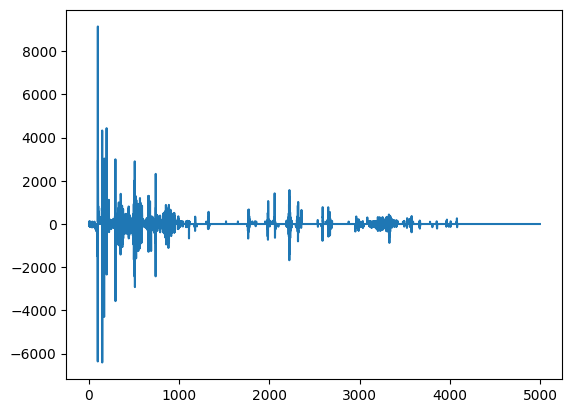

In [107]:
dct.plot(high = 5000)
dct.make_wave().make_audio()

При пороговом значении 100 до звук звучат весьма похоже на то, что было до компрессии.

In [108]:
filter(dct,1000)

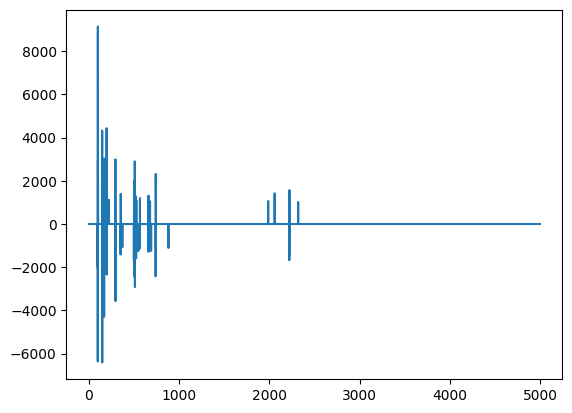

In [109]:
dct.plot(high = 5000)
dct.make_wave().make_audio()

При пороге 1000 сегмент ещё узнаваем, хотя уже труднее различить отдельные «голоса» и ноты мелодии.

In [110]:
filter(dct,2000)

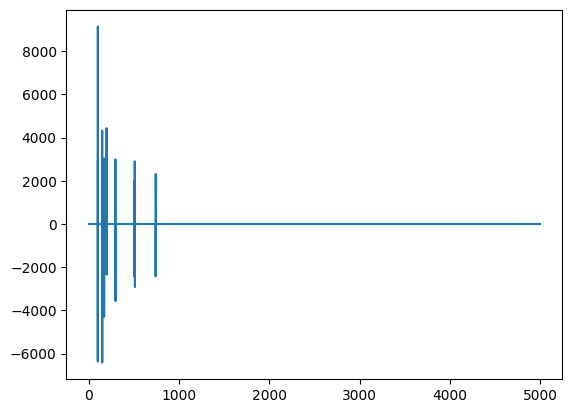

In [111]:
dct.plot(high = 5000)
dct.make_wave().make_audio()

При этом пороговом значении совершенно вропадает какое-либо ощущения ритма. Звук похож на один длинный аккорда с эхо.

# Упражнение 6.3

В репозитории этой книги есть блокнот Jupyter под названием phase.ipnyb, в котором исследуется влияние фазы на восприятие звука. Прочтите этот блокнот и «погоняйте» примеры. Выберите иной сегмент звука и повторите эксперименты. Можно ли найти некие общие соотношения в фазовой структуре звука и его восприятии?

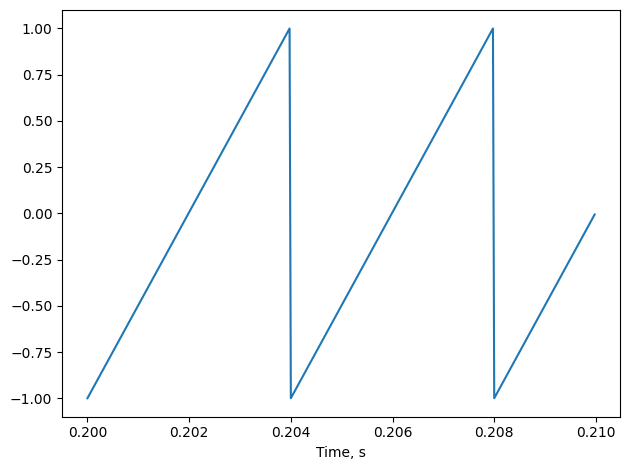

In [112]:
from thinkdsp import SawtoothSignal

signal = SawtoothSignal(freq=250, offset=0)
wave = signal.make_wave(duration=0.5, framerate=40000)
wave.segment(start=0.2,duration=0.01).plot()
decorate(xlabel='Time, s')
wave.make_audio()

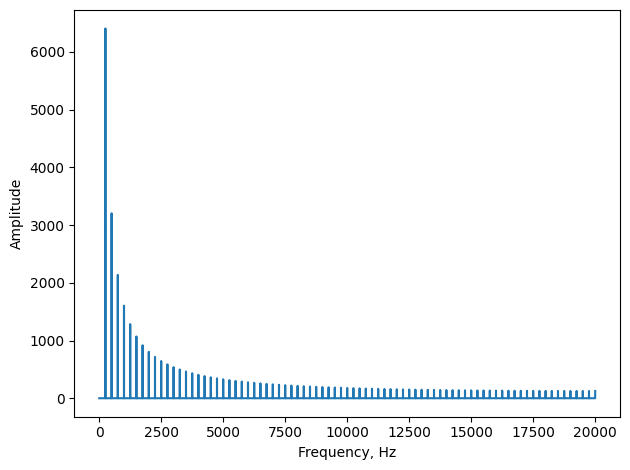

In [113]:
spectrum = wave.make_spectrum()
spectrum.plot()
decorate(xlabel='Frequency, Hz',
         ylabel='Amplitude')

In [114]:
def plot_angle(spectrum, thresh=1):
    angles = spectrum.angles
    angles[spectrum.amps < thresh] = np.nan
    plt.plot(spectrum.fs, angles, 'x')
    decorate(xlabel='Frequency, Hz',
             ylabel='Phase, rad')

In [115]:
def plot_three(spectrum, thresh=1):
    plt.figure(figsize=(10, 4))
    plt.subplot(1,3,1)
    spectrum.plot()
    plt.subplot(1,3,2)
    plot_angle(spectrum, thresh=thresh)
    plt.subplot(1,3,3)
    wave = spectrum.make_wave()
    wave.unbias()
    wave.normalize()
    wave.segment(duration=0.01).plot()
    display(wave.make_audio())

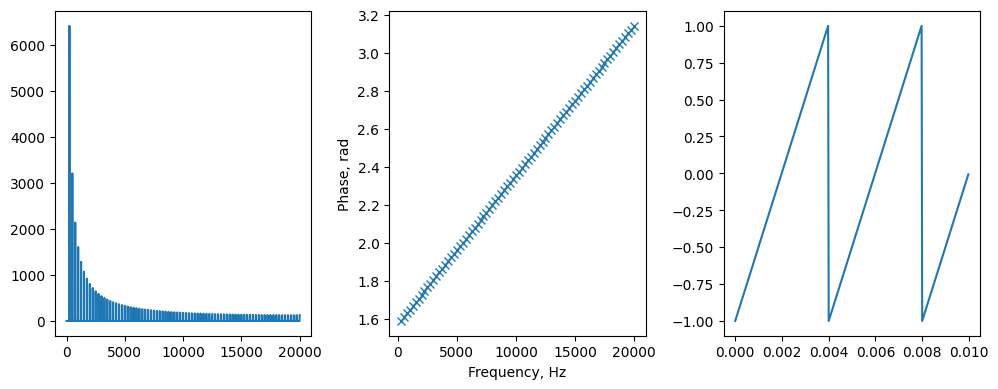

In [116]:
plot_three(spectrum)

Зададим значение всем значимым фазам – 0:

In [117]:
def zero_angle(spectrum):
    res = spectrum.copy()
    res.hs = res.amps
    return res

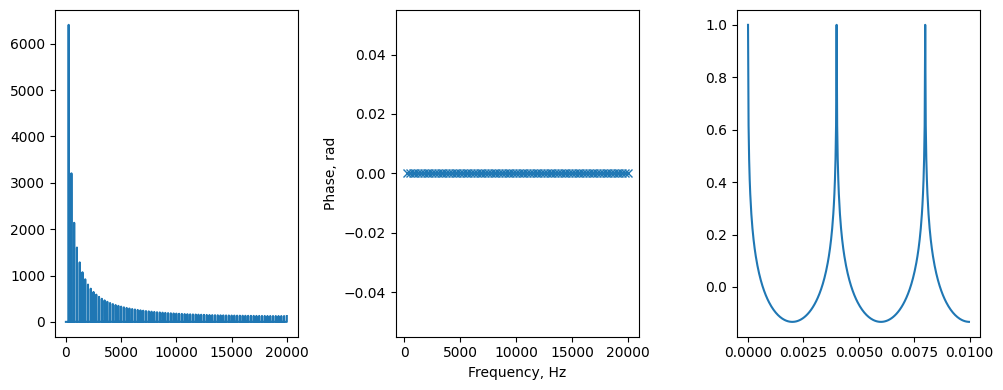

In [118]:
spectrum2 = zero_angle(spectrum)
plot_three(spectrum2)

Можно услышать, что форма сигнала очень сильно изменилась, при этом звучание осталось таким же. Единственное заметное изменение – громкость, но как нам подсказывает руководство, это связано с нормализацией, а не с изменениями в фазе.

Выберем в качестве значения фазы ненулевой угол.

In [119]:
def rotate_angle(spectrum, offset):
    res = spectrum.copy()
    res.hs *= np.exp(1j * offset)
    return res

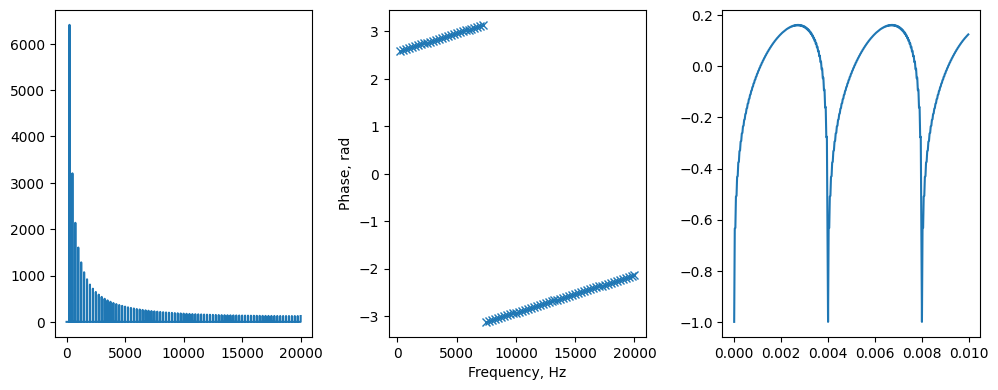

In [120]:
spectrum3 = rotate_angle(spectrum, 1)
plot_three(spectrum3)

Аналогично: форма сигнала снова сильно изменилось, при этом звучание осталоось такм же.

Попробуем назначить случайную фазу.

In [121]:
def random_angle(spectrum):
    res = spectrum.copy()
    angles = np.random.uniform(0, np.pi * 2, len(spectrum))
    res.hs *= np.exp(1j * angles)
    return res

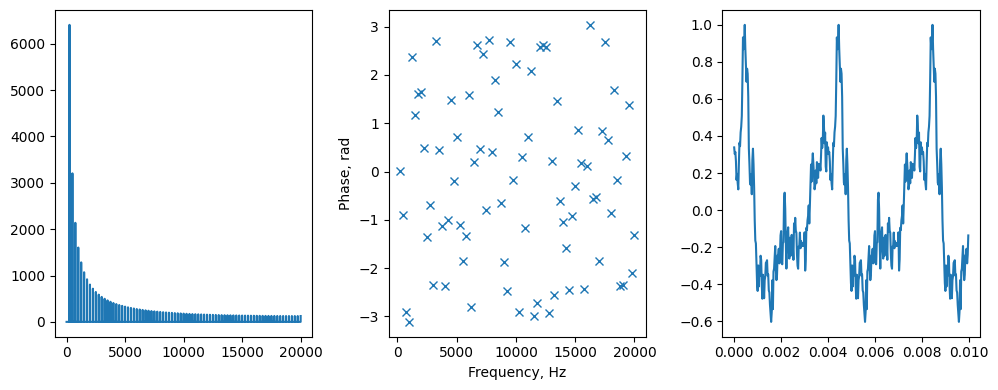

In [122]:
spectrum4 = random_angle(spectrum)
plot_three(spectrum4)

Только в этом случае появляется заметная разница в звучании сигнала. Он становится более "звенящим".

По исследованным примерам можно сделать вывод, что человек в большинстве ситуаций "глух" к изменению фазы сигнала.